# Install

In [1]:
!pip install -q gdown

# Imports

In [2]:
import os
import math
import copy
import random
import time
from datetime import datetime
from functools import partial
from pathlib import Path
from typing import Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2

from einops import rearrange
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

import wandb

print('✅ All imports successful')

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ All imports successful


# Config

In [3]:
CONFIG = {
    "model": "Swin",
    "variant": "tiny",
    "exp_no": 4,
    
    "seed": 42,
    
    "num_classes": 4,
    "input_dim": 224,

    "epochs": 100,
    "batch_size": 64,
    "lr": 3e-4,
    "weight_decay": 0.05,
    # "warmup_epochs": 3,
    "patience": 10,
    "delta": 1e-3,
    "max_saved_models": 5,

    "class_weights": [0.613, 0.839, 1.364, 2.26],

    "mean":  [0.1438080370426178, 0.1438080370426178, 0.1438080370426178],
    "std": [0.233843594789505, 0.233843594789505, 0.233843594789505],

    "csv_dir": "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv",
    "root_dir": "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    "output_dir": "/kaggle/working/",

    "use_wandb": False,
    "wandb_project": "kidney-stone-ct",
}

CONFIG["root_dir"] = Path(CONFIG["root_dir"])
CONFIG["output_dir"] = Path(CONFIG["output_dir"])
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONFIG["device"] = device

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])
print(f"✅ Device: {device}")
print(f"✅ Model: {CONFIG["model"]}-{CONFIG['variant']}, Experiment: {CONFIG["exp_no"]}, epochs: {CONFIG['epochs']}, lr: {CONFIG['lr']}")

✅ Device: cuda
✅ Model: Swin-tiny, Experiment: 4, epochs: 100, lr: 0.0003


# Utility classes & functions

In [4]:
# Define color codes for terminal
class Colors:
    RESET = '\033[0m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'

def display_progress_bar(batch_idx, num_batches, loss, accuracy):
    """
    Function to display a colored progress bar.
    Args:
        batch_idx: Current batch index
        num_batches: Total number of batches
        loss: Current loss value
        accuracy: Current accuracy value
    """
    progress = (batch_idx + 1) / num_batches
    bar_length = 40  # Length of the progress bar (number of '==' chars)
    filled_length = int(bar_length * progress)
    bar = f"{Colors.GREEN}{'=' * filled_length}{Colors.RED}{'-' * (bar_length - filled_length)}{Colors.RESET}"

    print(f'\r[{bar}] {batch_idx + 1}/{num_batches} | {Colors.YELLOW}Loss:{Colors.RESET} {loss:.3f} | {Colors.YELLOW}Accuracy:{Colors.RESET} {accuracy:.2f}%', end='', flush=True)

In [5]:
import matplotlib.pyplot as plt

def plot_result(history, title="Training Progress", save_path=None):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', color='tomato')
    plt.plot(epochs, history['val_loss'], label='Validation', color='steelblue')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', color='mediumseagreen')
    plt.plot(epochs, history['val_acc'], label='Validation', color='black')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'Plot saved to {save_path}')
    plt.show()

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(
                model.state_dict()
            )
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_model(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)

In [7]:
import os
from typing import Optional, Any
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        scheduler: Optional[Any] = None,
    ):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

    def _run_epoch(self, loader, training=True, show_progress=True):
        self.model.train() if training else self.model.eval()

        running_loss = 0.0
        correct = 0
        total = 0
        all_preds, all_targets = [], []
        num_batches = len(loader)

        with torch.set_grad_enabled(training):
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                if training:
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                running_loss += loss.item()
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

                all_preds.extend(preds.cpu().tolist())
                all_targets.extend(targets.cpu().tolist())

                if show_progress:
                    current_loss = running_loss / (batch_idx + 1)
                    current_acc = 100.0 * correct / total

                    display_progress_bar(
                        batch_idx=batch_idx,
                        num_batches=num_batches,
                        loss=current_loss,
                        accuracy=current_acc,
                    )

        if show_progress:
            print()

        epoch_loss = running_loss / num_batches
        epoch_acc = 100.0 * accuracy_score(all_targets, all_preds)

        return epoch_loss, epoch_acc, all_preds, all_targets

    def fit(
        self,
        trainloader,
        valloader,
        epochs=10,
        patience=5,
        delta=1e-4,
        model_name="model",
        topk=5,
    ):
        best_vloss = float("inf")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        start_time = time.time()
        early_stopping = EarlyStopping(patience=patience, delta=delta)
        topk_models = []

        for epoch in range(epochs):
            model_path = f"{model_name}_e{epoch+1}_{timestamp}.pt"

            print(f"\nEpoch {epoch + 1}/{epochs} - Training")
            t_loss, t_acc, _, _ = self._run_epoch(
                trainloader, training=True, show_progress=True
            )
            v_loss, v_acc, _, _ = self._run_epoch(
                valloader, training=False, show_progress=True
            )

            if self.scheduler:
                self.scheduler.step()

            # Log Metrics
            self.history["train_loss"].append(t_loss)
            self.history["train_acc"].append(t_acc)
            self.history["val_loss"].append(v_loss)
            self.history["val_acc"].append(v_acc)

            # Top K model saved
            if v_loss < best_vloss:
                best_vloss = v_loss
                best_model_weights = {
                    k: v.cpu().clone() for k, v in self.model.state_dict().items()
                }
                torch.save(best_model_weights, model_path)
                print(
                    f"\n--> NEW RECORD: Best model saved (Val loss: {best_vloss:.4f})"
                )
                topk_models.append((v_loss, model_path))
                topk_models.sort(key=lambda x: x[0])

                if topk_models is not None and len(topk_models) > topk:
                    _, worst_path = topk_models.pop(-1)
                    if os.path.exists(worst_path):
                        os.remove(worst_path)

            # Early Stopping
            early_stopping(val_loss=v_loss, model=self.model)

            if early_stopping.early_stop:
                print(
                    f"\nEarly stopping at epoch {epoch+1} with best validation loss: {early_stopping.best_loss:.4f}"
                )
                early_stopping.load_best_model(self.model)
                break

            print(f"\nTrain Loss: {t_loss:.4f}, Train Acc: {t_acc:.2f}%")
            print(f"Validation Loss: {v_loss:.4f}, Validation Acc: {v_acc:.2f}%")

        elapsed = time.time() - start_time
        print(f"\nTraining complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

        return self.history

    def evaluate(self, testloader, model_path=None):
        if model_path:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))

        loss, acc, preds, targets = self._run_epoch(
            testloader, training=False, show_progress=True
        )

        metrics = {
            "loss": loss,
            "accuracy": acc / 100,
            "precision": precision_score(
                targets, preds, average="weighted", zero_division=0
            ),
            "f1": f1_score(targets, preds, average="weighted", zero_division=0),
        }

        print("\n" + "=" * 25 + "\nTEST SET RESULTS\n" + "=" * 25)

        for k, v in metrics.items():
            print(f"{k.capitalize():<10}: {v:.4f}")

        return preds, targets, metrics

In [8]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [9]:
def get_dataset_mean_std(loader):
    ch_sum = ch_sq_sum = 0.0
    n = 0
    for data, _ in loader:
        ch_sum    += torch.mean(data, dim=[0, 2, 3])
        ch_sq_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        n += 1
    mean = ch_sum / n
    std  = (ch_sq_sum / n - mean ** 2).sqrt()
    return mean, std

# Dataset

In [10]:
class KidneyDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        self.csv = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        img_path = self.root_dir / row['diag'] / (row['image_id'] + '.jpg')
        img = Image.open(img_path).convert('RGB')
        label = row['target']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

# Train/Test/Val Split

In [11]:
temp_dataset = KidneyDataset(CONFIG['csv_dir'], CONFIG['root_dir'], transform=None)
all_labels   = temp_dataset.csv['Class']
indices      = list(range(len(temp_dataset)))

train_indices, temp_indices = train_test_split(
    indices,
    test_size=0.30,
    stratify=all_labels,
    random_state=CONFIG['seed'],
    shuffle=True
)
temp_labels = [all_labels[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.50,
    stratify=temp_labels,
    random_state=CONFIG['seed'],
    shuffle=True
)

print(f'Dataset total : {len(indices)}')
print(f'Train         : {len(train_indices)} ({len(train_indices)/len(indices)*100:.1f}%)')
print(f'Validation    : {len(val_indices)} ({len(val_indices)/len(indices)*100:.1f}%)')
print(f'Test          : {len(test_indices)} ({len(test_indices)/len(indices)*100:.1f}%)')

Dataset total : 12446
Train         : 8712 (70.0%)
Validation    : 1867 (15.0%)
Test          : 1867 (15.0%)


# Dataset mean & std
- skipped if values are pre-filled in Conifg

In [12]:
if CONFIG['mean'] is None or CONFIG['std'] is None:
    print('Computing dataset mean & std on the training split...')
    stats_transform = v2.Compose([
        v2.Resize((CONFIG['input_dim'], CONFIG['input_dim'])),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
    stats_base    = KidneyDataset(CONFIG['csv_dir'], CONFIG['root_dir'], transform=stats_transform)
    stats_dataset = Subset(stats_base, train_indices)
    stats_loader  = DataLoader(stats_dataset, batch_size=64, shuffle=False)

    mean, std = get_dataset_mean_std(stats_loader)
    CONFIG['mean'] = mean.tolist()
    CONFIG['std']  = std.tolist()
    print(f'  ➜ Paste these into CONFIG to skip next time:')
    print(f'    "mean": {CONFIG["mean"]},')
    print(f'    "std" : {CONFIG["std"]},')
else:
    print(f'Using cached stats — mean: {CONFIG["mean"]}, std: {CONFIG["std"]}')

Using cached stats — mean: [0.1438080370426178, 0.1438080370426178, 0.1438080370426178], std: [0.233843594789505, 0.233843594789505, 0.233843594789505]


# Transform & Dataloaders

In [13]:
mean = CONFIG['mean']
std  = CONFIG['std']
input_dim  = CONFIG['input_dim']

train_transform = v2.Compose([
    v2.Resize((input_dim, input_dim)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=5),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

val_transform = v2.Compose([
    v2.Resize((input_dim, input_dim)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

train_base = KidneyDataset(CONFIG['csv_dir'], CONFIG['root_dir'], transform=train_transform)
val_base = KidneyDataset(CONFIG['csv_dir'], CONFIG['root_dir'], transform=val_transform)
test_base  = KidneyDataset(CONFIG['csv_dir'], CONFIG['root_dir'], transform=val_transform)

train_dataset = Subset(train_base, train_indices)
val_dataset = Subset(val_base, val_indices)
test_dataset = Subset(test_base, test_indices)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    pin_memory=True,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    pin_memory=True,
    num_workers=2
)


print(f"Training set: {len(train_dataset)}")
print(f"Val set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

Training set: 8712
Val set: 1867
Test set: 1867


# Model & Optimizer

In [14]:
from torchvision.models import swin_t

model = swin_t(
    weights=None,
    num_classes=CONFIG["num_classes"]
)

# Count parameters
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Define loss and optimizer
class_weights = torch.tensor(CONFIG['class_weights'], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# def warmup_cosine_lambda(epoch, warmup_epochs, total_epochs):
#     if epoch < warmup_epochs:
#         return (epoch + 1) / warmup_epochs
#     progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
#     return 0.5 * (1 + math.cos(math.pi * progress))

# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=lambda e: warmup_cosine_lambda(e, CONFIG['warmup_epochs'], CONFIG['epochs'])
# )

trainer = Trainer(
    model=model,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    # scheduler=scheduler
)

print('✅ Trainer ready')

Total parameters: 27522430
Trainable parameters: 27522430
✅ Trainer ready


# Run Training

In [15]:
history = trainer.fit(
    trainloader=train_loader,
    valloader=val_loader,
    epochs=CONFIG['epochs'],
    patience=CONFIG['patience'],
    delta=CONFIG['delta'],
    model_name=f"{CONFIG["model"].lower()}_{CONFIG["variant"]}_exp{CONFIG["exp_no"]}",
    topk=CONFIG['max_saved_models']
)


Epoch 1/100 - Training
[========================================] 137/137 | Loss: 1.283 | Accuracy: 38.12%
[========================================] 30/30 | Loss: 1.254 | Accuracy: 33.58%

--> NEW RECORD: Best model saved (Val loss: 1.2542)

Train Loss: 1.2827, Train Acc: 38.12%
Validation Loss: 1.2542, Validation Acc: 33.58%

Epoch 2/100 - Training
[========================================] 137/137 | Loss: 1.182 | Accuracy: 45.14%
[========================================] 30/30 | Loss: 1.174 | Accuracy: 51.79%

--> NEW RECORD: Best model saved (Val loss: 1.1739)

Train Loss: 1.1816, Train Acc: 45.14%
Validation Loss: 1.1739, Validation Acc: 51.79%

Epoch 3/100 - Training
[========================================] 137/137 | Loss: 1.149 | Accuracy: 47.61%
[========================================] 30/30 | Loss: 1.149 | Accuracy: 44.46%

--> NEW RECORD: Best model saved (Val loss: 1.1493)

Train Loss: 1.1495, Train Acc: 47.61%
Validation Loss: 1.1493, Validation Acc: 44.46%

Epoch 4/1

# Training Curves

Plot saved to /kaggle/working/swin_tiny_exp4_curves.png


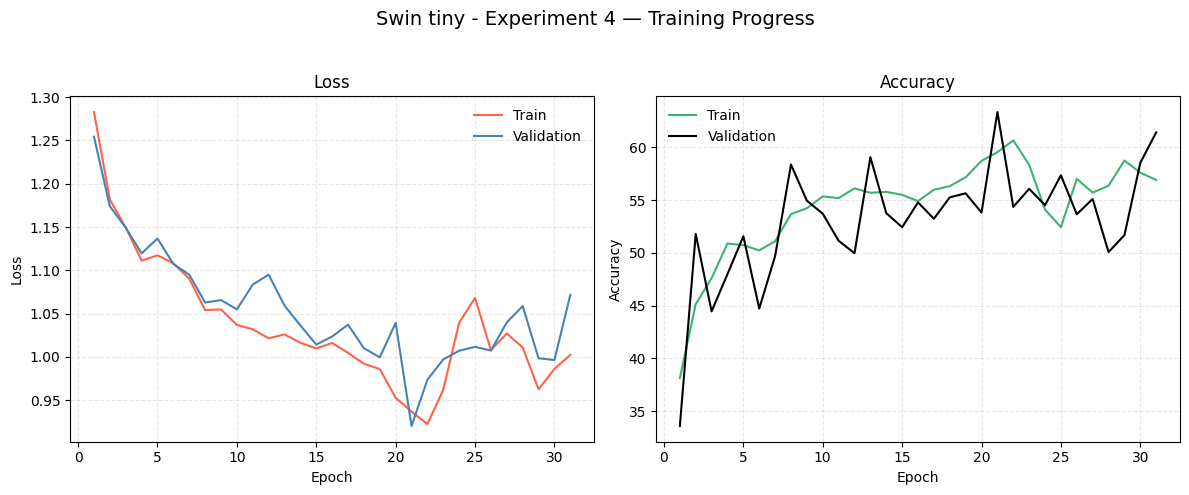

In [16]:
plot_result(
    history,
    title=f"{CONFIG["model"]} {CONFIG["variant"]} - Experiment {CONFIG["exp_no"]} — Training Progress",
    save_path=CONFIG['output_dir'] / f'{CONFIG["model"].lower()}_{CONFIG["variant"]}_exp{CONFIG["exp_no"]}_curves.png'
)

# Test Evaluation

In [17]:
saved_models = sorted(
    CONFIG['output_dir'].glob(f"{CONFIG["model"].lower()}_{CONFIG["variant"]}_exp{CONFIG["exp_no"]}*.pt"),
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

if saved_models:
    best_model_path = saved_models[0]
    print(f'Using checkpoint: {best_model_path.name}')
else:
    best_model_path = None
    print('No checkpoint found — evaluating with current model weights')

preds, targets, metrics = trainer.evaluate(test_loader, model_path=best_model_path)

Using checkpoint: swin_tiny_exp4_e21_20260218_154123.pt
[========================================] 30/30 | Loss: 0.916 | Accuracy: 64.60%

TEST SET RESULTS
Loss      : 0.9160
Accuracy  : 0.6460
Precision : 0.6848
F1        : 0.6408


# Confusion Matrix

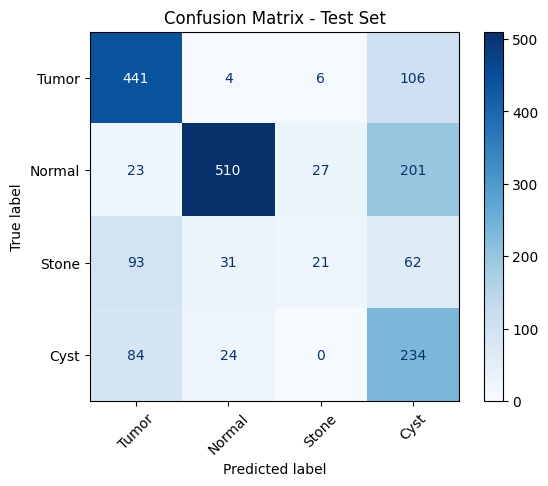

In [18]:
CLASS_NAMES = ['Tumor', 'Normal', 'Stone', 'Cyst']

cm   = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.savefig(CONFIG['output_dir'] / f'{CONFIG["model"].lower()}_{CONFIG["variant"]}_exp{CONFIG["exp_no"]}_confusion_matrix.png',
            dpi=150, bbox_inches='tight')
plt.show()